In [1]:
library(repr)
options(repr.plot.width=6, repr.plot.height=5)

In [2]:
library(tidyverse)
library(chromVAR)
library(motifmatchr)
library(Matrix)
library(SummarizedExperiment)
library(BSgenome.Hsapiens.UCSC.hg38)
library(pheatmap)
library(TFBSTools)
library(BiocParallel)
library(purrr)
register(MulticoreParam(10))
set.seed(2019)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply

In [3]:
setwd("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/")

# chromVAR analysis 1 - chromVAR + Jaspar 2020 motifs
**Inputs**
1. *Peaks*: These are peaks centered at summit with uniform width of 500 bp as recommended by chromVAR. Files are under `/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/diffbind_consensu_min2overlap.bed`. First 3 columns are standard bed, the 4th column is peak intensity as calculated from MACS2.
2. *Annovation*: Jaspar 2020 motifs

In [4]:
samplesheet <- read.csv('samplesheet2.csv', stringsAsFactors = F)

# Peaks
peak.file <- "/c/groups/sanjana_lab/cdai/TFscreen/atac/diffbind_consensu_min2overlap.bed"
peaks <- getPeaks(peak.file, sort_peaks = T)

peaks <- resize(peaks, width = 500, fix = "center")

my_counts_matrix <- read.table("diffbind_consensu_min2overlap_readcounts.txt", header = T) %>% as.matrix

depth <- apply(my_counts_matrix, 2, sum)
colData <- column_to_rownames(samplesheet, 'SampleID')
colData <- add_column(colData, depth) # add read depth per sample

fragment_counts <- SummarizedExperiment(assays = list(counts = my_counts_matrix),
                                        rowRanges = peaks, colData = colData)

fragment_counts.addGC <- addGCBias(fragment_counts, genome = BSgenome.Hsapiens.UCSC.hg38)

# each peak must have at least 10 reads across all 12 samples to be included
fragment_counts.filtered <- filterPeaks(fragment_counts.addGC, min_fragments_per_peak = 10, 
                                       non_overlapping = T)

ERROR: Error: '/c/groups/sanjana_lab/cdai/TFscreen/atac/diffbind_consensu_min2overlap.bed' does not exist.


#### Annotations

Get JASPAR2020 motifs. Then construct a motif - gene_name lookup table. In addition, add columns to indicate if a motif is a TF or hit TF.

In [ ]:
# New method: use downloaded JASPAR2020
jaspar_2020 <- readJASPARMatrix("JASPAR2020_combined_matrices_20191030.txt", matrixClass = "PFM")

#120 hit list
hitlist <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/HS_td-VStd+_td-VSdox120.csv', header = F, stringsAsFactors = F) %>% pull
#TF list
tflist <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/TFlist.csv', stringsAsFactors = F, col.names='gene_name') %>% pull(var = gene_name)
hitlist <- c(hitlist, c('NEUROG1', 'NEUROG2')) # adding NERUOG1/2 to hit list

# construct base motif_lookup table
motif_lookup <- TFBSTools::name(jaspar_2020) %>% 
                data.frame(stringsAsFactors = F) %>% 
                rownames_to_column("motif") %>% 
                mutate(gene_name=str_extract(`.`, "[a-zA-Z:0-9\\-]+")) %>%
                select(motif, gene_name)

# function to check if a tf name is in the substring of jaspar name
mystrfunc <- function(stringA, target) {
    # string A is a possible gene name, scalar
    # target is a vector of proper gene names
    # match if any target is a substring in string A, if so return True
    stringA <- rep(stringA, length(target))
    test <- unlist(map2(stringA, target, ~ str_detect(.x, .y)))
    return(any(test))
}

#motif_lookup <- motif_lookup  %>% mutate(is_hit = map(gene_name, ~ if_else(mystrfunc(.x, hitlist), "Yes", "No"))) %>%
                 #mutate(is_tf = map(gene_name, ~ if_else(mystrfunc(.x, tflist), "Yes", "No"))) 

is_hit <- map(motif_lookup$gene_name, ~ if_else(mystrfunc(.x, hitlist), "Yes", "No")) %>% unlist
is_tf <- map(motif_lookup$gene_name, ~ if_else(mystrfunc(.x, tflist), "Yes", "No")) %>% unlist

motif_lookup <- motif_lookup %>% add_column(is_hit = is_hit, is_tf = is_tf)

#### Deviations

In [ ]:
# get motif matches with peaks
motif_ix <- matchMotifs(jaspar_2020, fragment_counts.filtered, genome = BSgenome.Hsapiens.UCSC.hg38)

# computing deviations
dev <- computeDeviations(object = fragment_counts.filtered, annotations = motif_ix)

In [ ]:
# Add motif's gene names and whethere it's a hit / tf or not
# some motifs has 2 or 3 variants with the same gene name, thus taking the mean of all motif scores for the same gene
dev.scores <- deviationScores(dev) %>% 
                as.data.frame %>% 
                rownames_to_column('motif') %>% 
                left_join(motif_lookup, by = 'motif') %>%
                select(A1:is_tf) %>% 
                group_by(gene_name, is_hit, is_tf) %>% 
                summarise_all(mean) %>%
                ungroup()

In [ ]:
dev.scores %>% filter(str_detect(gene_name, 'IN'))

---

## Clustering based on correlation

In [9]:
sample_cor <- getSampleCorrelation(dev)

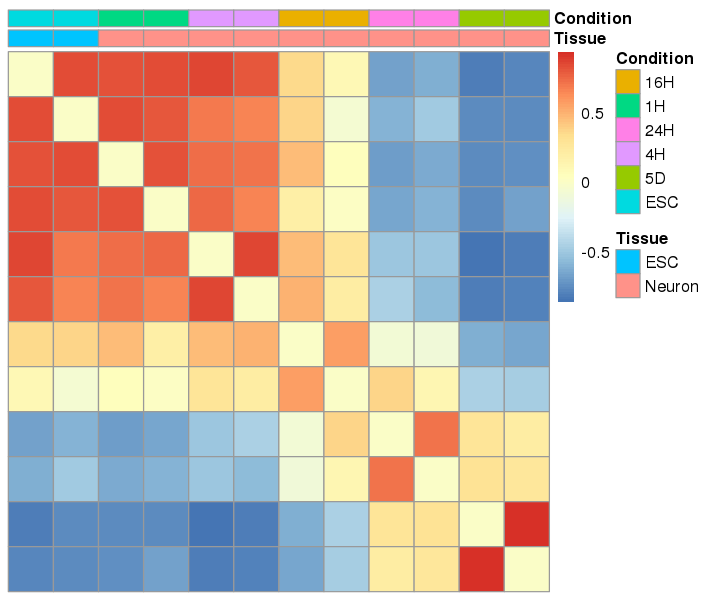

In [12]:
pheatmap(as.dist(sample_cor), annotation = data.frame(colData(dev)[,c(1,3)]), clustering_distance_rows = as.dist(1-sample_cor), clustering_distance_cols = as.dist(1-sample_cor),
        cluster_rows = F, show_rownames = T, cluster_cols = F, show_colnames = T)

In [10]:
dev.scores %>% filter(gene_name == 'ZBTB18')

gene_name,is_hit,is_tf,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZBTB18,Yes,Yes,-2.97136,-1.380703,-1.167483,-2.285474,-1.194408,0.8362943,0.112931,0.4502776,0.1300537,0.4581698,1.160191,1.236917


## Hit TF motifs' accessibility

In [5]:
options(repr.plot.width=7, repr.plot.height=7)
dev.scores %>% filter(is_hit == "Yes") %>% 
                select(gene_name, A1:A12) %>% arrange(gene_name) %>%
                column_to_rownames('gene_name')  %>%
                pheatmap(cluster_rows = F, show_rownames = T, cluster_cols = F, fontsize=7)

ERROR: Error in eval(lhs, parent, parent): object 'dev.scores' not found


##### Heatmap for all TF (~1800) motif binding sites accessibility 

** cluster rows (TF motifs) by hits vs non hits **

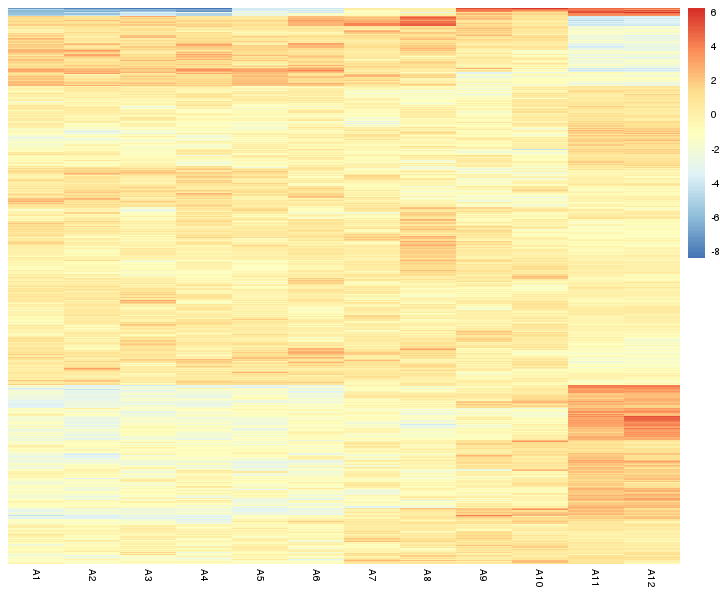

In [15]:
dev.scores %>%  filter(is_tf == "Yes") %>% select(gene_name, A1:A12)  %>% column_to_rownames('gene_name')  %>%
                        pheatmap(cluster_rows = T, show_rownames = F, cluster_cols = F, show_colnames=T, fontsize=6, treeheight_row=0)

#### Is there an enrichment of open vs closed in hit TFs vs other TFs? or What are the groups of open vs closed TFs?

In [16]:
dev.scores %>% head

gene_name,is_hit,is_tf,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALX3,No,Yes,-1.6384447,-2.8446575,-1.8827820,-2.0961426,-2.4567807,-1.8130310,0.019649268,0.45831325,0.11274948,0.4392262,2.0574681,2.4345177
AR,No,Yes,-1.8444513,-1.2043915,-1.3958242,-1.4052146,-1.0476070,-0.7026961,0.996668890,-0.08521765,1.58243067,1.4792939,0.9980039,0.1986967
ARGFX,No,Yes,-2.1638243,-2.7691897,-2.1060805,-2.0190687,-2.7565552,-3.0051652,-0.001254575,-0.25617104,1.03010236,0.5883838,2.5788242,3.0302946
ARNT::HIF1A,No,Yes,0.3273486,0.8879503,0.3463007,0.6437213,-0.4228751,0.3061073,-0.569705629,-0.01452481,-0.07988779,0.3860256,-0.6696215,-0.2358546
ARNT2,No,Yes,-0.4369646,0.8230277,0.2317603,-0.2771520,-1.2620006,0.1065155,-1.980499557,-2.41117116,-0.66115140,-0.6514473,1.3497916,1.3835475
ASCL1,No,Yes,-1.8865133,-2.4921049,-1.5194095,-1.8064744,-1.1076559,-0.6505122,1.132335574,-0.49695308,0.24476842,0.1323490,1.8266022,1.7238736


In [17]:
library(gridExtra)
#grid.arrange(p1, p2, ncol=2)


Attaching package: ‘gridExtra’

The following object is masked from ‘package:Biobase’:

    combine

The following object is masked from ‘package:BiocGenerics’:

    combine

The following object is masked from ‘package:dplyr’:

    combine



In [18]:
g1 <- ggplot(dev.scores) + geom_histogram(aes(x=A1)) + xlim(c(-5,5))
g2 <- ggplot(dev.scores) + geom_histogram(aes(x=A3))  + xlim(c(-5,5))
g3 <- ggplot(dev.scores) + geom_histogram(aes(x=A5)) + xlim(c(-5,5))
g4 <- ggplot(dev.scores) + geom_histogram(aes(x=A7)) + xlim(c(-5,5))
g5 <- ggplot(dev.scores) + geom_histogram(aes(x=A9)) + xlim(c(-5,5))
g6 <- ggplot(dev.scores) + geom_histogram(aes(x=A11)) + xlim(c(-5,5))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 6 rows containing non-finite values (stat_bin).”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”

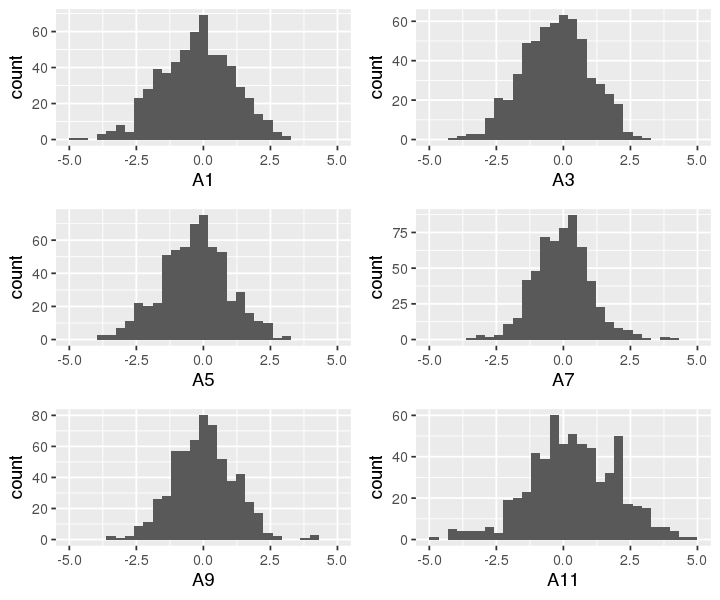

In [19]:
grid.arrange(g1, g2, g3, g4, g5, g6, ncol=2)

**ZBTB18 sequence logo**

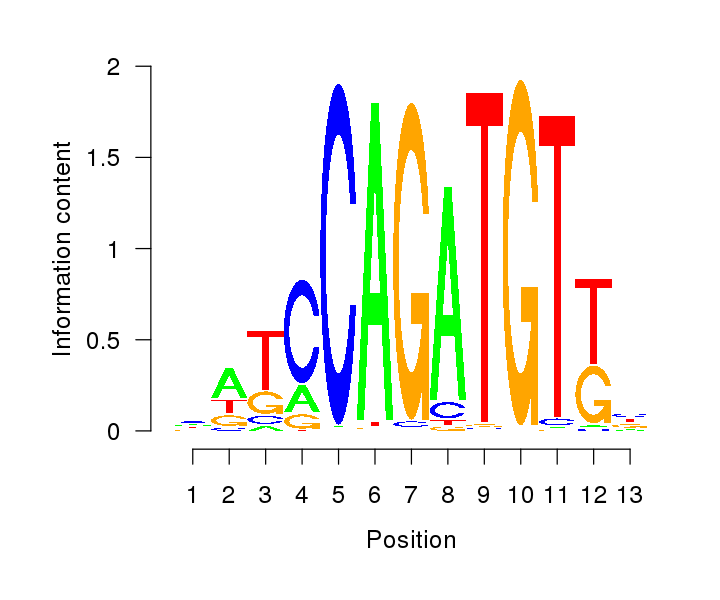

In [20]:
#sequence logo for ZBTB18
mx <- toPWM(Matrix(jaspar_2020)$ZBTB18, "prob" )
seqLogo::seqLogo(mx)

## Find TF targets

Use motifMatchr to match all promoter region first. Then intersect ATACseq peaks with promoter region (that are matched with a certain motif). The result is a list of peaks from ATACseq that belong to a list of genes' promoter region, with which the motif(TF) can bind to. In otherwords, given a TF motif, we now have a list of genes that have been assayed to show different binding accessibility to the TF motif. 

zbtb18 motif ID `MA0698.1`

##### Support functions for this section 


In [11]:
getSubjectGRanges <- function(feature.granges, matchMotifResult, motif_id) {
    # inputs:
    # feature.granges = GRange object of feature, e.g. promoter
    # matchMotifResult - matchMotifs result of feature region, and motifs
    # motif.db - motifs, such as jaspar 2018 motifs
    # hitgenelist - hit gene list, a vector
    # motif_lookup - motif look up dataframe, indicating whether a motif is hit or not, and gene name
    # outputs:
    # matched_features: the GRange object of features that match to the specified motif (motif_id)
    
    motif_matches_matrix <- motifMatches(matchMotifResult) # matrix of matching motifs and peak GRanges
    motif_match_per_feature_idx <- motif_matches_matrix[, motif_id] %>% as.matrix %>% which # row index of matched feature granges
    matched_features <- feature.granges[motif_match_per_feature_idx]
    return(matched_features) # return feature promoter (GRanges) that match to JASPAR motifs
}

In [12]:
findDeviationPerTarget <- function(devScore.peak, motif_ix, motif_id, feature_granges, min.overlap = 10, hitgenelist) {
    # inputs:
    # deviationResult: chromVar computed deviation
    # fragment.counts: RangedSummarizedExperiment from chromVAR, including filtered peaks and readcounts
    # subject.granges: GRange object that you want to intersect with. For example, Promoter ranges. Note, it should have gene_name or gene_id included in mcols
    # min.overlap: minimum overlap for GenomicRanges::findOverlaps method
    # output: 
    # deviation.score.per.target: given genomic feature region, e.g. promoter region that maps to ZBTB18 motif, chromVAR deviation results, and fragment counts, report the genes 
    # that are potential targets of the given motif (determined by subject.granges), and report deviation score.
    
    peak_idx <- which(motif_mx[, motif_id])  # indices of peaks that match a particular motif
    devScore.peak.motif <- devScore.peak[peak_idx] # deviation scores of peaks that match to a particular motif
    
    # find overlap between query (a motif matched peak set), and subject (such as promoters)
    hitTarget.overlap <- GenomicRanges::findOverlaps(query = devScore.peak.motif, subject = feature_granges, minoverlap = min.overlap, ignore.strand = T)
    
    # get gene_names from the feature granges
    gene_names <- feature_granges[subjectHits(hitTarget.overlap)] %>%
                    elementMetadata %>% 
                    as.data.frame %>% 
                    pull(gene_name)
    
    # concatenate overlap results (peaks that are within promoter or gene regions). 
    # Output dataframe includes peaks that are within genomic feature in subject.granges, and its annotation (gene_name)
    target_devScore.peak.motif <- devScore.peak.motif[queryHits(hitTarget.overlap)] %>% 
                                    mcols  %>% # deviation scores stored in mcols 
                                    as.data.frame %>% 
                                    add_column('gene_name' = gene_names) %>% 
                                    dplyr::select(A1:gene_name) %>% 
                                    filter(gene_name %in% hitgenelist) %>% 
                                    group_by(gene_name) %>% 
                                    summarise_all(sum) %>% 
                                    arrange(gene_name)
    return(target_devScore.peak.motif)
}

In [13]:
getHitTF <- function(dev.score.df, motif_lookup, A.cols, B.cols) {
    ######################### FUNCTION: 
    #### Select Hit TF's motifs that has increasing deviation scores, return a list of such motif names
    # dev.score.df: deviation scores matrix
    # A.cols: vector, the column names of ES, eg. c("A1","A2")
    # B.cols: vector, the column names of another time point, eg. c("A11","A12")
    
    dev.scores.hit <- dev.score.df %>% filter(is_hit == "Yes") %>% dplyr::select(gene_name, A.cols, B.cols)

    # calculate mean difference between two time points
    dev.mean.A <- dplyr::select(dev.scores.hit, A.cols) %>% apply(MARGIN = 1, mean) # mean of time point A
    dev.mean.B <- dplyr::select(dev.scores.hit, B.cols) %>% apply(MARGIN = 1, mean) # mean of time point B
    dev.BvsA <- dev.mean.B - dev.mean.A # B - A
    dev.scores.hit <- add_column(dev.scores.hit, "B_A"= dev.BvsA) # add difference of means as a column

    # select TF motifs that have increasing accessibility
    TF <- dev.scores.hit %>% dplyr::filter(dev.BvsA > 0) %>% pull(gene_name)
    TF_motif_ids <- motif_lookup %>% filter(gene_name %in% TF) %>% pull(motif)
    return(TF_motif_ids) # return hit TF jaspar motif name
}

In [14]:
getTargetDeviationScore <- function(TF_motif_ids, devScore.peak, motif_ix, feature_granges, min.overlap = 10, hitgenelist, A.cols, B.cols, motif_lookup) {
    ######################### FUNCTION: 
    #### Based on previously selected TF_motif_id, find the genes that has peaks in its promoter region (or feature region) that
    #### have matches to given jaspar motif. Result is a dataframe of Source TF name and Target Gene name (TF could bind to based on motif match).
    #### Return dataframe columns: 1. TF 2. target 3. deviation difference at given time point (eg. 5D - ES)
    # TF_motif_ids: a vector of motif names
    # devScore.peak: peak's deviation scores calculated earlier
    # motif_ix: each peak's motif matching result
    # feature_granges: a GRange object of features, e.g. promoters
    # hitgenelist: list of git genes
    # A.cols: eg. for ES: c("A1", "A2")
    # B.cols: eg. for 5D: c("A11", "A12")
    # motif_lookup: motif_lookup dataframe
    
    target_genes <- list()
    for (motif_id in TF_motif_ids) {
        target <- findDeviationPerTarget(devScore.peak = devScore.peak, motif_ix = motif_ix, motif_id = motif_id, feature_granges = feature_granges, min.overlap = min.overlap, hitgenelist = hitgenelist)
        target.A.mean <- target %>% dplyr::select(A.cols) %>% apply(1, mean)
        target.B.mean <- target %>% dplyr::select(B.cols) %>% apply(1, mean)
        target.BvsA <- target.B.mean - target.A.mean
        target <- target %>% add_column("B_A"=target.BvsA)
        target <- target %>% filter(`B_A` > 0)
        target_genes[[motif_lookup[motif_lookup$motif == motif_id,'gene_name']]] <- target
    }
    # expand list to dataframe
    target_genes.df <- do.call(rbind,target_genes)
    target_genes.df <- target_genes.df %>% rownames_to_column("TF") %>% mutate_at("TF", ~ str_remove(.x, "\\.[0-9]+$"))
    return(target_genes.df) 
}

In [59]:
combineRnaProfileWithAtac <- function(target_genes.df, RNA_temporal_file) {
    ######################### FUNCTION: 
    #### Taking the RNA seq temporal expression profile (code 1 - 31), and augment the TF-Target deviation score change dataframe.
    #### Returning a dataframe with source and target gene expression temporal profile
    # target_genes.df - returned dataframe from getTargetDeviationScore function
    # RNA_temporal_file - "../RNAseq_WT_temporal.csv"
    
    rna_temporal <- read.table(RNA_temporal_file, sep = ",", stringsAsFactors = F, header=T)
    tf_target_intera <- target_genes.df %>% dplyr::select(TF, gene_name, B_A)
    out.nodes <- tf_target_intera %>% pull(TF) %>% unique
    in.nodes <- tf_target_intera %>% pull(gene_name) %>% unique
    all.nodes <- c(out.nodes, in.nodes) %>% unique
    
    tf_target_intera <- tf_target_intera %>% left_join(rna_temporal[,2:3], by = c("TF" = "gene_name")) %>%
                        rename("B_A"="devS.dif", "expr.flag"="source.temporal") %>%
                        left_join(rna_temporal[,2:3], by = c("gene_name" = "gene_name")) %>%
                        rename("expr.flag"="target.temporal")
    return(tf_target_intera)
}

In [53]:
rna_temporal <- read.table("../RNAseq_WT_temporal.csv", sep = ",", stringsAsFactors = F, header=T)

##### 1 First load motifs and calculate peak deviation score

In [16]:
# use previous loaded jaspar_2020
# use previous calculated motif_ix

In [17]:
# calculate deviation scores for each peak
dev.peak <- computeDeviations(object = fragment_counts.filtered)

Annotations not provided, so chromVAR being run on individual peaks...


In [18]:
motif_mx <- motifMatches(motif_ix)

In [19]:
# get deviation score per peak
devScore.peak <- deviationScores(dev.peak)

# Above dataframe doesn't have peak coordinates. Thus get coordinates
devScore.peak <- rowRanges(motif_ix) %>% as.data.frame %>%
                        dplyr::select(seqnames, start, end) %>%
                        cbind(devScore.peak) %>%
                        makeGRangesFromDataFrame(keep.extra.columns = T)

##### 2 Then get GRanges of the promoters that match interested TF motifs

In [20]:
# get annotated promoter region bed
promoter_region <- read.table("Protein_coding_gene_promoters_V2.bed", header = F, stringsAsFactors = F, 
                              col.names = c("seqname","start","end","gene_id","gene_name","strand")) %>% 
                                dplyr::select(seqname, start, end, strand, gene_id, gene_name)
# convert to GRanges object
promoter_region <- GenomicRanges::makeGRangesFromDataFrame(promoter_region, keep.extra.columns = T)

#### 3 For each time point:
- get TF of interest
- get binding targets of each TF, that are within promoter region
- get diviation scores of such target genes
- get pair-wise (TF-Target) diviation score change for each time point (Get only positive changing pairs)
- agument with RNA temporal profile
- save to csv

In [49]:
A_cols <- c("A1", "A2")
B_cols <- list("H1_ES"=c("A3", "A4"), "H4_ES"=c("A5", "A6"), "H16_ES"=c("A7", "A8"), "D1_ES"=c("A9", "A10"), "D5_ES"=c("A11", "A12"))

In [62]:
for (timepoint in names(B_cols)) {
    print(timepoint)
    source_tf_motif_names <- getHitTF(dev.score.df = dev.scores, motif_lookup = motif_lookup, A.cols = A_cols, B.cols = B_cols[[timepoint]])
    targets_devs_diff <- getTargetDeviationScore(TF_motif_ids = source_tf_motif_names, devScore.peak = devScore.peak, motif_ix = motif_ix, 
                                                 feature_granges = promoter_region,min.overlap = 10, hitgenelist = hitlist, 
                                                 A.cols = A_cols, B.cols = B_cols[[timepoint]], motif_lookup = motif_lookup)
    tf_target_interaction <- combineRnaProfileWithAtac(target_genes.df = targets_devs_diff, RNA_temporal_file = "../RNAseq_WT_temporal.csv")
    outfile <- paste0("TF_target_interactions_with_RNAseq_", str_extract(timepoint, "[A-Z0-9]+"), ".csv")
    write.table(tf_target_interaction, outfile, sep = ",", row.names = F, col.names = T, quote = F)
}

[1] "H1_ES"
[1] "H4_ES"
[1] "H16_ES"
[1] "D1_ES"
[1] "D5_ES"


*Manual version of above steps*
#### 3a 5D vs. ES: Get motif list of interest.

*A list of TF motifs that are increasing accessibility at D5 vs ES:*

In [66]:
# deviation scores for just 5D vs ES for hit TF motifs
dev.scores.ES_5D.hit <- dev.scores %>%  filter(is_hit == "Yes") %>% dplyr::select(gene_name, A1:A2, A11:A12)

# calculate mean difference between two time points
dev.ES.mean <- dev.scores.ES_5D.hit[,2:3] %>% apply(MARGIN = 1, mean)
dev.5D.mean <- dev.scores.ES_5D.hit[,4:5] %>% apply(MARGIN = 1, mean)
dev.5D_sub_ES <- dev.5D.mean - dev.ES.mean
dev.scores.ES_5D.hit <- dev.scores.ES_5D.hit %>% add_column("5D-ES"=dev.5D_sub_ES)

# select TF motifs that have increasing accessibility
TF <- dev.scores.ES_5D.hit %>% filter(`5D-ES` > 0) %>% pull(gene_name)
TF_motif_ids <- motif_lookup %>% filter(gene_name %in% TF) %>% pull(motif)

For each interested TF motif, get its target gene's deviation score

In [67]:
target_genes <- list()

for (motif_id in TF_motif_ids) {
    target <- findDeviationPerTarget(devScore.peak = devScore.peak, motif_ix = motif_ix, motif_id = motif_id, feature_granges = promoter_region, min.overlap = 10, hitgenelist = hitlist)
    target.ES.mean <- target %>% dplyr::select(A1,A2) %>% apply(1, mean)
    target.5D.mean <- target %>% dplyr::select(A11,A12) %>% apply(1, mean)
    target.5D_sub_ES <- target.5D.mean - target.ES.mean
    target <- target %>% add_column("5D_ES"=target.5D_sub_ES)
    target <- target %>% filter(`5D_ES` > 0)
    target_genes[[motif_lookup[motif_lookup$motif == motif_id,'gene_name']]] <- target
}

# expand list to dataframe
target_genes.df <- do.call(rbind,target_genes)
target_genes.df <- target_genes.df %>% rownames_to_column("TF") %>% mutate_at("TF", ~ str_remove(.x, "\\.[0-9]+$"))

In [69]:
target_genes.df %>% filter(str_detect(TF, "ZBTB"))

TF,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,5D_ES
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZBTB18,ASB1,-1.8858189,-0.9228178,-0.01104276,-0.9444771,-1.4735481,-1.3234762,-0.4397580,-2.1088181,-0.9030400,-0.19124735,2.79472444,2.9515949,4.2774780
ZBTB18,NEUROG3,-0.9259605,0.8984119,0.67405247,0.3587213,-0.2440216,-0.3941011,-2.0698751,0.1961931,0.6606385,-0.71853576,0.03955371,0.2002458,0.1336740
ZBTB18,SNAI2,-0.2965848,-0.7137229,-2.19013102,0.6895857,-1.0772203,0.5380495,-1.1356099,0.2759903,-0.5846649,-1.00955340,0.76243340,1.1815794,1.4771602
ZBTB18,ZBTB18,-1.1495754,-1.4392789,-0.90574768,-1.0290373,-1.6251045,0.2082278,-0.2528989,1.2864422,1.4880309,0.09788326,1.10749545,-0.5541955,1.5710771
ZBTB18,ZNF136,-0.6579076,0.1267606,-0.23304116,-0.9511228,-0.6405848,0.1396195,0.9509900,-0.7570244,0.1627870,-0.93639633,0.31786209,0.7152565,0.7821328


##### 5 Cross reference ATAC seq TF-Target interactions in RNA seq

---

In [171]:
dev.scores %>% filter(gene_name == "NEUROG2")

motif,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,gene_name,is_hit,is_tf
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
MA0669.1,-2.927776,-4.872323,-3.301028,-3.906312,-3.868612,-1.627386,0.5470498,0.7853264,3.412203,2.425836,2.948557,1.619116,NEUROG2,No,Yes


### Statistics  on motif data

In [384]:
# total TFs
jaspar_2020 %>% names %>% str_extract("[a-zA-Z0-9]+") %>% unique %>% length

[1] 567

In [385]:
# total motifs
jaspar_2020 %>% length

[1] 639

In [386]:
# number of motifs that are in hit list
motif_lookup %>% filter(is_hit == "Yes") %>% pull(gene_name) %>% unique %>% length

[1] 57